<a href="https://colab.research.google.com/github/Shubham1509-ux/Nifty-50-Stocks-Prediction/blob/main/LondonAirbnbMarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import geopandas as gpd
import folium
from textblob import TextBlob
import nltk
nltk.download('punkt')
from sklearn.preprocessing import StandardScaler

# Load the Excel file
df_combined = pd.read_excel('/content/listings-2.xlsx')

# Inspect the first few rows
print(df_combined.head())
print(df_combined.info())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


       id last_scraped       source  \
0  312761   2024-03-21  city scrape   
1   13913   2024-03-20  city scrape   
2   15400   2024-03-20  city scrape   
3  159736   2024-03-20  city scrape   
4  165336   2024-03-21  city scrape   

                                                name  \
0  Spacious Central London Apartment by Hoxton Sq...   
1                Holiday London DB Room Let-on going   
2                Bright Chelsea  Apartment. Chelsea!   
3   A double Room 5mins from King's College Hospital   
4                      Charming Flat in Notting Hill   

                                         description  \
0  Very central location, in the middle of Shored...   
1  My bright double bedroom with a large window h...   
2  Lots of windows and light.  St Luke's Gardens ...   
3  Calm sunny double room with a queen size bed a...   
4  A stylish apartment close to Portobello market...   

                               neighborhood_overview  host_id host_name  \
0  Everything is

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy

# Download the necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load Spacy's English model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    return text

stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return words

stemmer = PorterStemmer()

def stem_words(words):
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

def lemmatize_words(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    return lemmatized_words


In [ ]:

# Example DataFrame
df = pd.DataFrame({
    'reviews': [
        "This is an amazing place! 100% recommend to anyone.",
        "The host was rude. Not coming back.",
        "Great location, but the room was dirty. Would not recommend.",
        "Perfect stay! Will definitely come again."
    ]
})

# Apply the preprocessing functions
df['cleaned_reviews'] = df['reviews'].apply(clean_text)
df['tokenized_reviews'] = df['cleaned_reviews'].apply(tokenize_and_remove_stopwords)

# Choose either stemming or lemmatization (do not typically use both)
df['stemmed_reviews'] = df['tokenized_reviews'].apply(stem_words)
df['lemmatized_reviews'] = df['cleaned_reviews'].apply(lemmatize_words)

# Display the results
print(df[['reviews', 'cleaned_reviews', 'tokenized_reviews', 'stemmed_reviews', 'lemmatized_reviews']])

                                             reviews  \
0  This is an amazing place! 100% recommend to an...   
1                The host was rude. Not coming back.   
2  Great location, but the room was dirty. Would ...   
3          Perfect stay! Will definitely come again.   

                                     cleaned_reviews  \
0      this is an amazing place  recommend to anyone   
1                  the host was rude not coming back   
2  great location but the room was dirty would no...   
3            perfect stay will definitely come again   

                                  tokenized_reviews  \
0               [amazing, place, recommend, anyone]   
1                        [host, rude, coming, back]   
2  [great, location, room, dirty, would, recommend]   
3                 [perfect, stay, definitely, come]   

                                 stemmed_reviews  \
0                [amaz, place, recommend, anyon]   
1                       [host, rude, come, back]   
2  [gr

In [ ]:
def preprocess_review(review):
    review = str(review)  # Ensure it's a string
    cleaned = clean_text(review)
    tokenized = tokenize_and_remove_stopwords(cleaned)
    lemmatized = lemmatize_words(' '.join(tokenized))
    return lemmatized

df['processed_reviews'] = df['reviews'].apply(preprocess_review)


In [ ]:
def spacy_preprocess_pipe(reviews):
    docs = nlp.pipe(reviews, batch_size=1000, n_process=-1)  # Adjust batch size and number of processes as needed
    processed_reviews = []
    for doc in docs:
        tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
        processed_reviews.append(tokens)
    return processed_reviews

# Apply SpaCy's parallel processing
df['processed_reviews'] = spacy_preprocess_pipe(df['reviews'])

In [ ]:
# Display the first few rows of the DataFrame, including the original reviews and the processed sentiment results
print(df[['reviews', 'processed_reviews']].head())


                                             reviews  \
0  This is an amazing place! 100% recommend to an...   
1                The host was rude. Not coming back.   
2  Great location, but the room was dirty. Would ...   
3          Perfect stay! Will definitely come again.   

                           processed_reviews  
0                [amazing, place, recommend]  
1                         [host, rude, come]  
2  [great, location, room, dirty, recommend]  
3          [perfect, stay, definitely, come]  


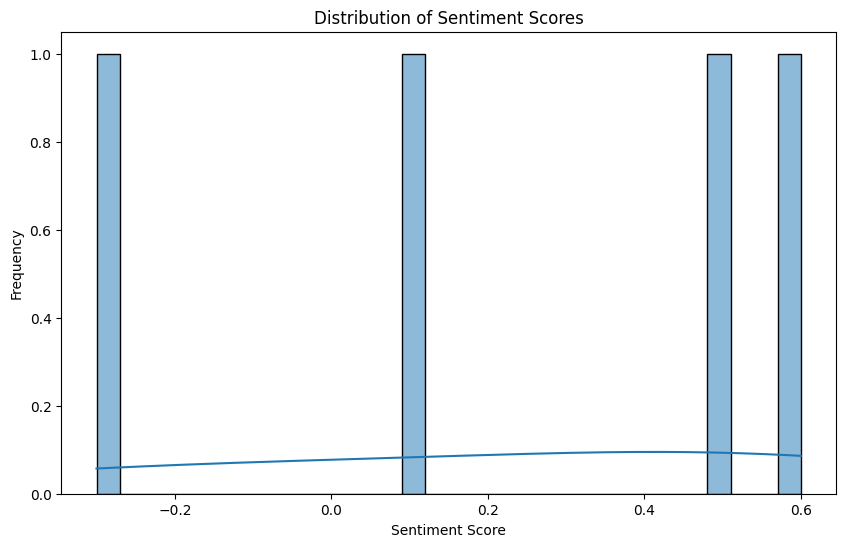

In [ ]:
# Assuming that 'processed_reviews' contains the sentiment polarity scores, you can plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['processed_reviews'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity), bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


In [ ]:
print(df.columns)

Index(['reviews', 'cleaned_reviews', 'tokenized_reviews', 'stemmed_reviews',
       'lemmatized_reviews', 'processed_reviews'],
      dtype='object')


In [ ]:
print(df_combined.columns)

Index(['id', 'last_scraped', 'source', 'name', 'description',
       'neighborhood_overview', 'host_id', 'host_name', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms',
       'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
       'number_of_reviews', 'numb

In [ ]:
# Example of merging along columns (most common scenario for different columns)
df_merge = pd.concat([df, df_combined], axis=1)

# Check the merged DataFrame
print(df_merge.columns)


Index(['reviews', 'cleaned_reviews', 'tokenized_reviews', 'stemmed_reviews',
       'lemmatized_reviews', 'processed_reviews', 'id', 'last_scraped',
       'source', 'name', 'description', 'neighborhood_overview', 'host_id',
       'host_name', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_3

In [ ]:
def safe_get_sentiment(text):
    if isinstance(text, list):
        return TextBlob(' '.join(text)).sentiment.polarity
    elif isinstance(text, str):
        return TextBlob(text).sentiment.polarity
    else:
        return None  # Or some other default value like 0

df_merge['sentiment_score'] = df_merge['processed_reviews'].apply(safe_get_sentiment)

In [ ]:
df_merge['occupancy_rate'] = 1 - (df_merge['availability_365'] / 365)


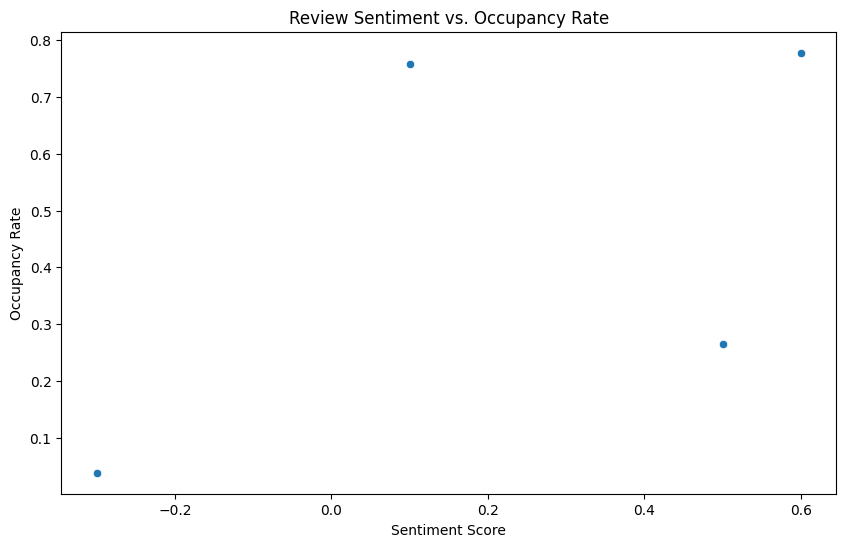

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_merge['sentiment_score'], y=df_merge['occupancy_rate'])
plt.title('Review Sentiment vs. Occupancy Rate')
plt.xlabel('Sentiment Score')
plt.ylabel('Occupancy Rate')
plt.show()


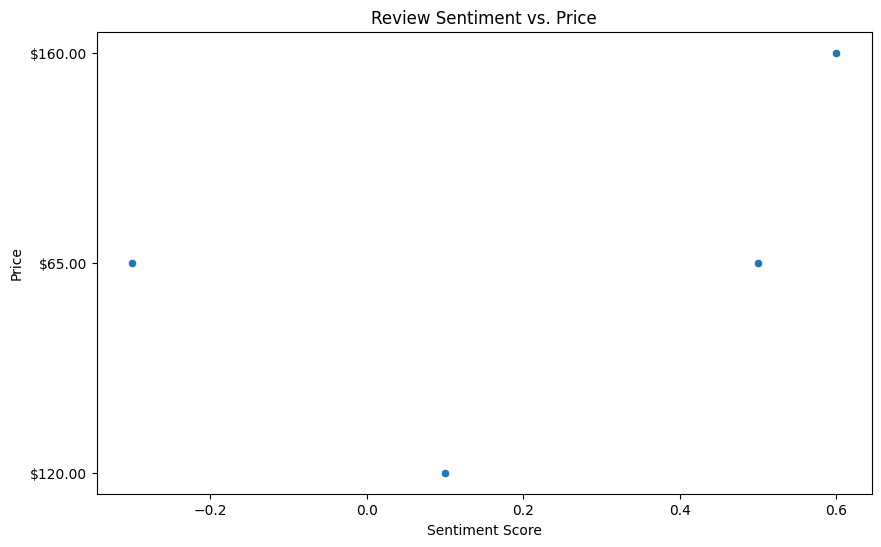

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_merge['sentiment_score'], y=df_merge['price'])
plt.title('Review Sentiment vs. Price')
plt.xlabel('Sentiment Score')
plt.ylabel('Price')
plt.show()


In [ ]:
 # Drop unnecessary columns
columns_to_drop = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'host_id', 'host_name', 'source','calendar_updated','host_has_profile_pic','availability_90','availability_60','availability_30','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','minimum_minimum_nights','review_scores_checkin']
df_combined = df_combined.drop(columns=columns_to_drop, errors='ignore')

# Verify that columns have been dropped
print(df_combined.columns)


Index(['name', 'description', 'neighborhood_overview', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listin

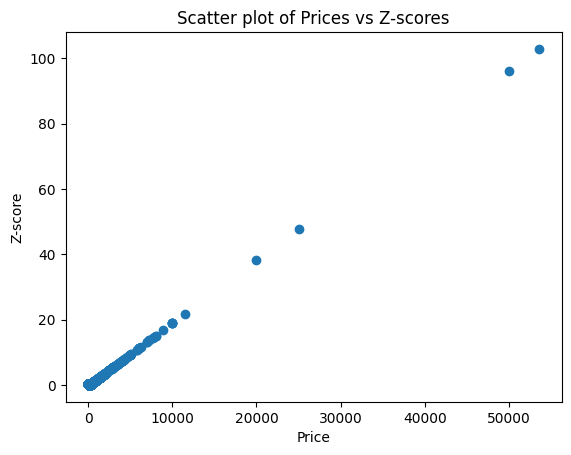

In [ ]:

# Assuming df_merge is your DataFrame and 'price' is the column of interest

# Remove any non-numeric characters from the 'price' column (e.g., '$', ',')
df_merge['price'] = df_merge['price'].replace({'\$': '', ',': ''}, regex=True)

# Convert the 'price' column to numeric
df_merge['price'] = pd.to_numeric(df_merge['price'], errors='coerce')

# Calculate Z-scores
df_merge['z_score'] = np.abs((df_merge['price'] - df_merge['price'].mean()) / df_merge['price'].std())

# Scatter plot of prices with Z-scores
import matplotlib.pyplot as plt

plt.scatter(df_merge['price'], df_merge['z_score'])
plt.xlabel('Price')
plt.ylabel('Z-score')
plt.title('Scatter plot of Prices vs Z-scores')
plt.show()



In [ ]:

# Basic descriptive statistics for all numeric columns
print(df_merge.describe())

                 id                   last_scraped       host_id  \
count  6.553500e+04                          65535  6.553500e+04   
mean   2.359384e+17  2024-03-20 18:26:23.044174848  1.286744e+08   
min    1.391300e+04            2024-03-19 00:00:00  2.594000e+03   
25%    1.902547e+07            2024-03-20 00:00:00  1.807884e+07   
50%    3.744939e+07            2024-03-21 00:00:00  5.956136e+07   
75%    6.546057e+17            2024-03-22 00:00:00  1.952055e+08   
max    9.029209e+17            2024-03-22 00:00:00  5.613776e+08   
std    3.536456e+17                            NaN  1.475313e+08   

       host_listings_count  host_total_listings_count      latitude  \
count         65530.000000               65530.000000  65535.000000   
mean             42.344071                  86.498230     51.509764   
min               1.000000                   1.000000     51.295937   
25%               1.000000                   1.000000     51.482316   
50%               2.000000      

In [ ]:
print(df_merge.columns)

Index(['reviews', 'cleaned_reviews', 'tokenized_reviews', 'stemmed_reviews',
       'lemmatized_reviews', 'processed_reviews', 'id', 'last_scraped',
       'source', 'name', 'description', 'neighborhood_overview', 'host_id',
       'host_name', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_3

In [ ]:

# Descriptive statistics for specific columns
print(df_merge[['price', 'occupancy_rate', 'bedrooms', 'bathrooms']].describe())

# Frequency distribution of a categorical variable
print(df_merge['property_type'].value_counts())

# Proportion of each category
print(df_merge['property_type'].value_counts(normalize=True))





              price  occupancy_rate      bedrooms     bathrooms
count  35411.000000    65535.000000  53558.000000  35436.000000
mean     187.081444        0.706175      1.602468      1.368128
std      518.814528        0.362224      1.079449      0.690780
min        0.000000        0.000000      0.000000      0.000000
25%       71.000000        0.427397      1.000000      1.000000
50%      125.000000        0.915068      1.000000      1.000000
75%      202.000000        1.000000      2.000000      1.500000
max    53588.000000        1.000000     50.000000     22.000000
property_type
Entire rental unit                   23064
Private room in rental unit          11217
Private room in home                  8238
Entire condo                          7126
Entire home                           5538
                                     ...  
Shared room in villa                     1
Shared room in serviced apartment        1
Earthen home                             1
Private room in camper/

In [ ]:
# Select only numeric columns from the DataFrame
numeric_df_merge = df_merge.select_dtypes(include=[np.number])

# Calculate and print the correlation matrix
correlation_matrix = numeric_df_merge.corr()
print("Correlation Matrix:\n", correlation_matrix)


Correlation Matrix:
                                                     id   host_id  \
id                                            1.000000  0.414161   
host_id                                       0.414161  1.000000   
host_listings_count                           0.138967  0.036224   
host_total_listings_count                     0.133442  0.042606   
latitude                                      0.000938 -0.001716   
longitude                                    -0.013685 -0.003281   
accommodates                                  0.080754  0.019048   
bathrooms                                     0.022737 -0.018218   
bedrooms                                     -0.006166 -0.052089   
beds                                          0.011711 -0.002397   
price                                         0.000556 -0.001907   
minimum_nights                               -0.018514  0.006666   
maximum_nights                               -0.002747 -0.002392   
minimum_minimum_nights     

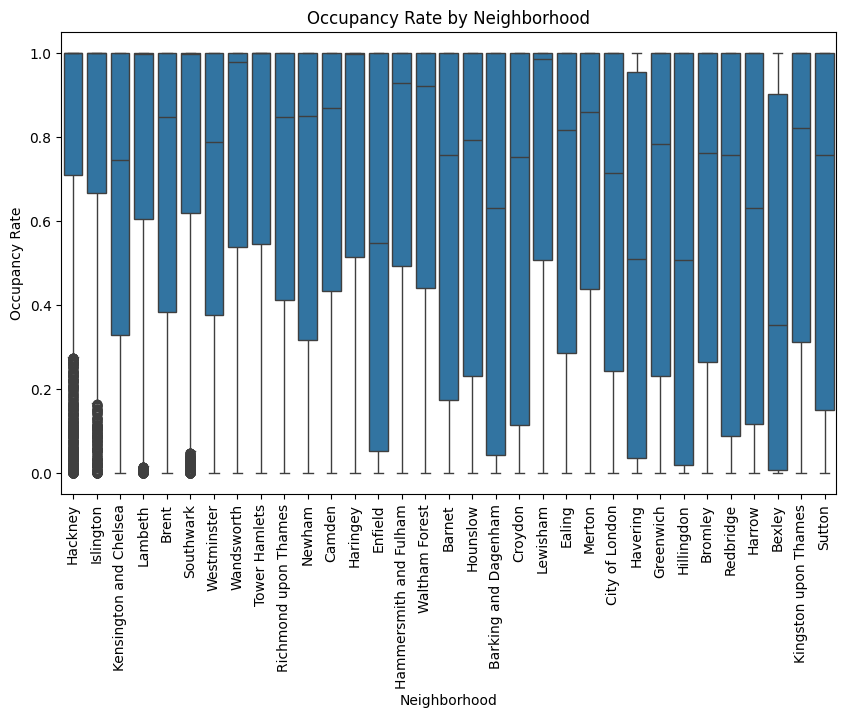

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='neighbourhood_cleansed', y='occupancy_rate', data=df_merge)
plt.title('Occupancy Rate by Neighborhood')
plt.xticks(rotation=90)
plt.xlabel('Neighborhood')
plt.ylabel('Occupancy Rate')
plt.show()

In [ ]:
import geopandas as gpd

# Load your GeoJSON data
geojson_file_path = '/content/london.geojson'

# Ensure the file exists at the given path and load it
geojson_data = gpd.read_file(geojson_file_path)

# Now you can use geojson_data in your code
print(geojson_data.head())


                   name  cartodb_id                created_at  \
0  Barking and Dagenham           1 2013-09-16 02:14:14+02:00   
1                Barnet           2 2013-09-16 02:14:14+02:00   
2                Bexley           3 2013-09-16 02:14:14+02:00   
3                 Brent           4 2013-09-16 02:14:14+02:00   
4               Bromley           5 2013-09-16 02:14:14+02:00   

                 updated_at                                           geometry  
0 2013-09-16 02:14:14+02:00  MULTIPOLYGON (((0.07263 51.53122, 0.07263 51.5...  
1 2013-09-16 02:14:14+02:00  MULTIPOLYGON (((-0.25216 51.58802, -0.25218 51...  
2 2013-09-16 02:14:14+02:00  MULTIPOLYGON (((0.19886 51.45817, 0.19886 51.4...  
3 2013-09-16 02:14:14+02:00  MULTIPOLYGON (((-0.2905 51.5357, -0.29056 51.5...  
4 2013-09-16 02:14:14+02:00  MULTIPOLYGON (((0.09379 51.32025, 0.09347 51.3...  


In [ ]:
print(geojson_data.columns)


Index(['name', 'cartodb_id', 'created_at', 'updated_at', 'geometry'], dtype='object')


In [ ]:
# Check for Timestamp columns
timestamp_columns = geojson_data.select_dtypes(include=['datetime64', 'datetime', 'timedelta']).columns
print("Timestamp columns before conversion:", timestamp_columns)

# Convert all Timestamp columns to string
for col in timestamp_columns:
    geojson_data[col] = geojson_data[col].astype(str)

# Recheck to ensure conversion
timestamp_columns_after = geojson_data.select_dtypes(include=['datetime64', 'datetime', 'timedelta']).columns
print("Timestamp columns after conversion:", timestamp_columns_after)


Timestamp columns before conversion: Index([], dtype='object')
Timestamp columns after conversion: Index([], dtype='object')


In [ ]:
for col in geojson_data.columns:
    if geojson_data[col].dtype == 'datetime64[ns]':
        geojson_data[col] = geojson_data[col].astype(str)
    elif geojson_data[col].apply(lambda x: isinstance(x, pd.Timestamp)).any():
        geojson_data[col] = geojson_data[col].astype(str)


In [ ]:
# Drop Timestamp columns if they are not needed
geojson_data = geojson_data.drop(columns=timestamp_columns)


In [ ]:
# Example of loading or creating neighbourhood_data
# Make sure your DataFrame includes the 'neighbourhood_cleansed' and 'occupancy_rate' columns
import pandas as pd

# Assuming you already have the DataFrame df_merge that includes the necessary data
neighbourhood_data = df_combined[['neighbourhood_cleansed', 'occupancy_rate']]

# Check if the DataFrame is loaded correctly
print(neighbourhood_data.head())


   neighbourhood_cleansed  occupancy_rate
0                 Hackney        0.778082
1               Islington        0.038356
2  Kensington and Chelsea        0.758904
3                 Lambeth        0.265753
4  Kensington and Chelsea        0.991781


In [ ]:
# Print the first feature to inspect its properties
print(geojson_data.head())


                   name  cartodb_id                 created_at  \
0  Barking and Dagenham           1  2013-09-16 02:14:14+02:00   
1                Barnet           2  2013-09-16 02:14:14+02:00   
2                Bexley           3  2013-09-16 02:14:14+02:00   
3                 Brent           4  2013-09-16 02:14:14+02:00   
4               Bromley           5  2013-09-16 02:14:14+02:00   

                  updated_at  \
0  2013-09-16 02:14:14+02:00   
1  2013-09-16 02:14:14+02:00   
2  2013-09-16 02:14:14+02:00   
3  2013-09-16 02:14:14+02:00   
4  2013-09-16 02:14:14+02:00   

                                            geometry  
0  MULTIPOLYGON (((0.07263 51.53122, 0.07263 51.5...  
1  MULTIPOLYGON (((-0.25216 51.58802, -0.25218 51...  
2  MULTIPOLYGON (((0.19886 51.45817, 0.19886 51.4...  
3  MULTIPOLYGON (((-0.2905 51.5357, -0.29056 51.5...  
4  MULTIPOLYGON (((0.09379 51.32025, 0.09347 51.3...  


In [ ]:
key_on='feature.properties.name'


In [ ]:
import folium

# Assuming the correct field in your GeoJSON is found under `properties.neighbourhood_cleansed`
key_on_field = 'feature.properties.name'  # Replace YOUR_ACTUAL_FIELD with the correct field name

# Create a folium map centered around London
london_map = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# Add a choropleth layer
folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=neighbourhood_data,
    columns=['neighbourhood_cleansed', 'occupancy_rate'],
    key_on=key_on_field,  # Use the corrected key
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Occupancy Rate (%)'
).add_to(london_map)

# Display the map
london_map


In [ ]:
df_merge['price'] = df_merge['price'].replace('[\$,]', '', regex=True).astype(float)

In [ ]:
# Define bins and labels
bins = [0, 100, 200, 300, df_merge['price'].max()]
labels = ['Low (0-100)', 'Medium (101-200)', 'High (201-300)', 'Very High (300+)']

# Create a new column for price categories
df_merge['price_category'] = pd.cut(df_merge['price'], bins=bins, labels=labels, include_lowest=True)

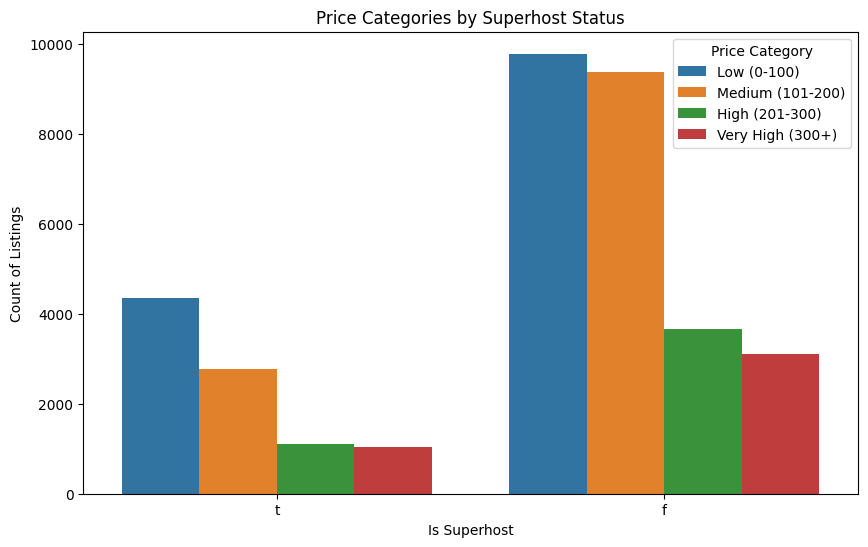

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='host_is_superhost', hue='price_category', data=df_merge)
plt.title('Price Categories by Superhost Status')
plt.xlabel('Is Superhost')
plt.ylabel('Count of Listings')
plt.legend(title='Price Category')
plt.show()

In [ ]:
import pandas as pd
from geopy.distance import geodesic

# Assuming you have coordinates for a major tourist attraction
tourist_attraction = (51.5074, -0.1278)  # Example: Big Ben in London

# Check if the columns 'latitude' and 'longitude' exist in df_merge
if 'latitude' in df_merge.columns and 'longitude' in df_merge.columns:
    # Calculate distance from each listing to the tourist attraction
    df_merge['distance_to_attraction'] = df_merge.apply(
        lambda row: geodesic((row['latitude'], row['longitude']), tourist_attraction).km, axis=1)
else:
    print("Error: 'latitude' and 'longitude' columns are missing in the DataFrame.")

# Now you can safely access the 'distance_to_attraction' column
if 'distance_to_attraction' in df_merge.columns:
    print(df_merge[['distance_to_attraction']].head())  # Display the first few values for verification
else:
    print("Error: 'distance_to_attraction' column was not created.")


   distance_to_attraction
0                3.898419
1                6.890253
2                3.549517
3                4.804183
4                5.864653


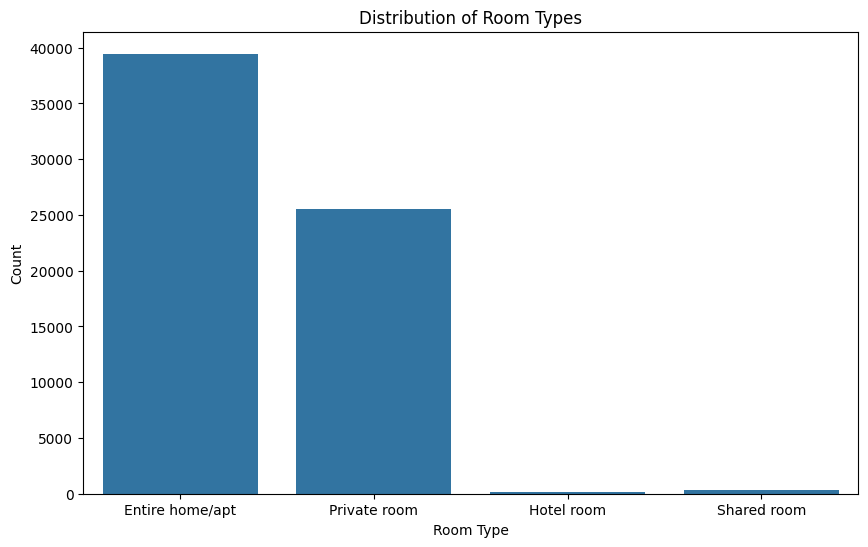

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='room_type', data=df_merge)
plt.title('Distribution of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.show()

In [ ]:
property_types = df_merge['property_type'].unique()
print(property_types)

['Entire rental unit' 'Private room in rental unit' 'Entire townhouse'
 'Entire home' 'Private room in home' 'Entire guesthouse'
 'Private room in townhouse' 'Entire condo' 'Private room in condo'
 'Room in serviced apartment' 'Room in aparthotel'
 'Entire serviced apartment' 'Private room in loft' 'Private room'
 'Private room in bed and breakfast' 'Entire guest suite' 'Houseboat'
 'Private room in serviced apartment' 'Private room in bungalow'
 'Private room in guesthouse' 'Shared room in home' 'Entire loft'
 'Entire cabin' 'Private room in yurt' 'Boat' 'Shared room in condo'
 'Private room in guest suite' 'Entire cottage' 'Private room in villa'
 'Private room in cottage' 'Tiny home' 'Entire place'
 'Private room in houseboat' 'Shared room in loft'
 'Room in bed and breakfast' 'Shared room in rental unit'
 'Private room in casa particular' 'Shepherdâ€™s hut'
 'Private room in vacation home' 'Room in boutique hotel' 'Shared room'
 'Shared room in bungalow' 'Camper/RV' 'Entire home/ap

In [ ]:


# Define a mapping dictionary
property_mapping = {
    'Entire rental unit': 'Entire Property',
    'Private room in rental unit': 'Private Room',
    'Entire townhouse': 'Entire Property',
    'Entire home': 'Entire Property',
    'Private room in home': 'Private Room',
    'Entire guesthouse': 'Entire Property',
    'Private room in townhouse': 'Private Room',
    'Entire condo': 'Entire Property',
    'Private room in condo': 'Private Room',
    'Room in serviced apartment': 'Shared Property',
    'Room in aparthotel': 'Shared Property',
    'Entire serviced apartment': 'Entire Property',
    'Private room in loft': 'Private Room',
    'Private room': 'Private Room',
    'Private room in bed and breakfast': 'Private Room',
    'Entire guest suite': 'Entire Property',
    'Houseboat': 'Unique Property',
    'Private room in serviced apartment': 'Private Room',
    'Private room in bungalow': 'Private Room',
    'Private room in guesthouse': 'Private Room',
    'Shared room in home': 'Shared Room',
    'Entire loft': 'Entire Property',
    'Entire cabin': 'Entire Property',
    'Private room in yurt': 'Private Room',
    'Boat': 'Unique Property',
    'Shared room in condo': 'Shared Room',
    'Private room in guest suite': 'Private Room',
    'Entire cottage': 'Entire Property',
    'Private room in villa': 'Private Room',
    'Private room in cottage': 'Private Room',
    'Tiny home': 'Unique Property',
    'Entire place': 'Entire Property',
    'Private room in houseboat': 'Private Room',
    'Shared room in loft': 'Shared Room',
    'Room in bed and breakfast': 'Shared Property',
    'Shared room in rental unit': 'Shared Room',
    'Private room in casa particular': 'Private Room',
    'Shepherd’s hut': 'Unique Property',
    'Private room in vacation home': 'Private Room',
    'Room in boutique hotel': 'Shared Property',
    'Shared room': 'Shared Room',
    'Shared room in bungalow': 'Shared Room',
    'Camper/RV': 'Unique Property',
    'Entire home/apt': 'Entire Property',
    'Entire vacation home': 'Entire Property',
    'Entire bungalow': 'Entire Property',
    'Private room in hut': 'Private Room',
    'Entire villa': 'Entire Property',
    'Private room in chalet': 'Private Room',
    'Private room in camper/rv': 'Private Room',
    'Shared room in townhouse': 'Shared Room',
    'Floor': 'Unique Property',
    'Earthen home': 'Unique Property',
    'Private room in hostel': 'Private Room',
    'Shared room in serviced apartment': 'Shared Room',
    'Shared room in hostel': 'Shared Room',
    'Private room in lighthouse': 'Private Room',
    'Private room in floor': 'Private Room',
    'Shared room in villa': 'Shared Room',
    'Room in hostel': 'Shared Property',
    'Private room in cabin': 'Private Room',
    'Private room in island': 'Private Room',
    'Barn': 'Unique Property',
    'Entire chalet': 'Entire Property',
    'Shared room in farm stay': 'Shared Room',
    'Shared room in bus': 'Shared Room',
    'Shared room in guesthouse': 'Shared Room',
    'Room in hotel': 'Shared Property',
    'Private room in tiny home': 'Private Room',
    'Campsite': 'Unique Property',
    'Private room in farm stay': 'Private Room',
    'Shared room in guest suite': 'Shared Room',
    'Religious building': 'Unique Property',
    'Shared room in boutique hotel': 'Shared Room',
    'Private room in earthen home': 'Private Room',
    'Private room in treehouse': 'Private Room',
    'Hut': 'Unique Property',
    'Private room in boat': 'Private Room',
    'Room in rental unit': 'Shared Property',
    "Private room in shepherd's hut": 'Private Room',
    'Private room in castle': 'Private Room',
    'Shared room in bed and breakfast': 'Shared Room',
    'Dome': 'Unique Property',
    'Tent': 'Unique Property',
    'Shared room in hotel': 'Shared Room',
    'Private room in nature lodge': 'Private Room',
    'Private room in religious building': 'Private Room',
    'Minsu': 'Unique Property',
    'Casa particular': 'Unique Property',
    'Riad': 'Unique Property',
    'Island': 'Unique Property',
    'Castle': 'Unique Property',
    'Tower': 'Unique Property',
    'Shared room in vacation home': 'Shared Room',
    'Farm stay': 'Unique Property',
    'Shipping container': 'Unique Property'
}


In [ ]:
# Apply the mapping to create a new column 'property_category'
df_merge['property_category'] = df_merge['property_type'].map(property_mapping)

# Check the distribution of the new categories
distribution = df_merge['property_category'].value_counts()
print(distribution)

property_category
Entire Property    39263
Private Room       24925
Shared Property      853
Shared Room          342
Unique Property      150
Name: count, dtype: int64


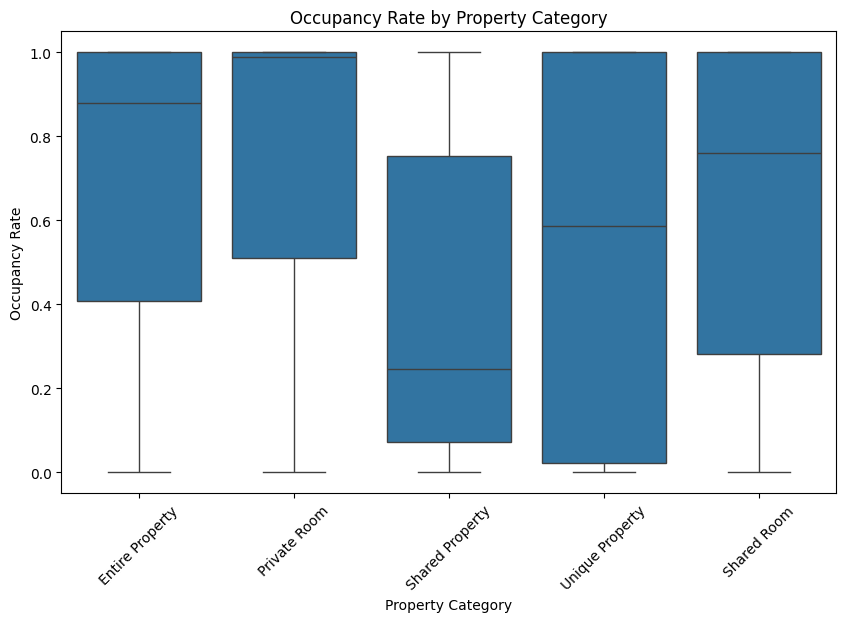

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='property_category', y='occupancy_rate', data=df_merge)
plt.title('Occupancy Rate by Property Category')
plt.xlabel('Property Category')
plt.ylabel('Occupancy Rate')
plt.xticks(rotation=45)
plt.show()

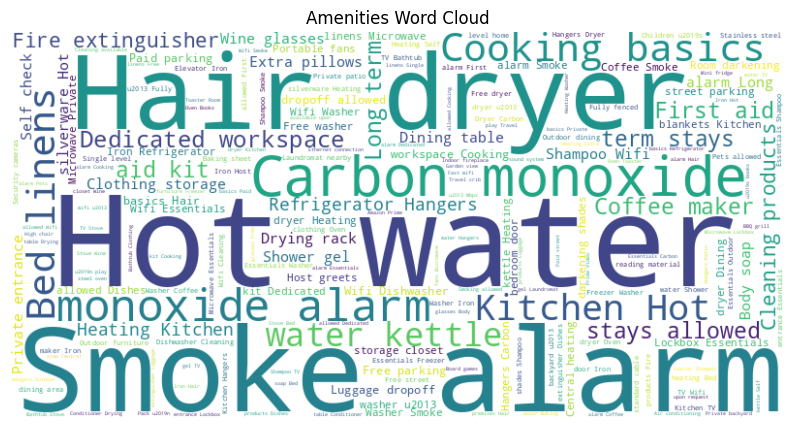

In [ ]:
from wordcloud import WordCloud

# Concatenate all amenities into one string
amenities = ' '.join(df_merge['amenities'].dropna().str.replace('[{}]', '', regex=True))

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(amenities)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Amenities Word Cloud')
plt.show()

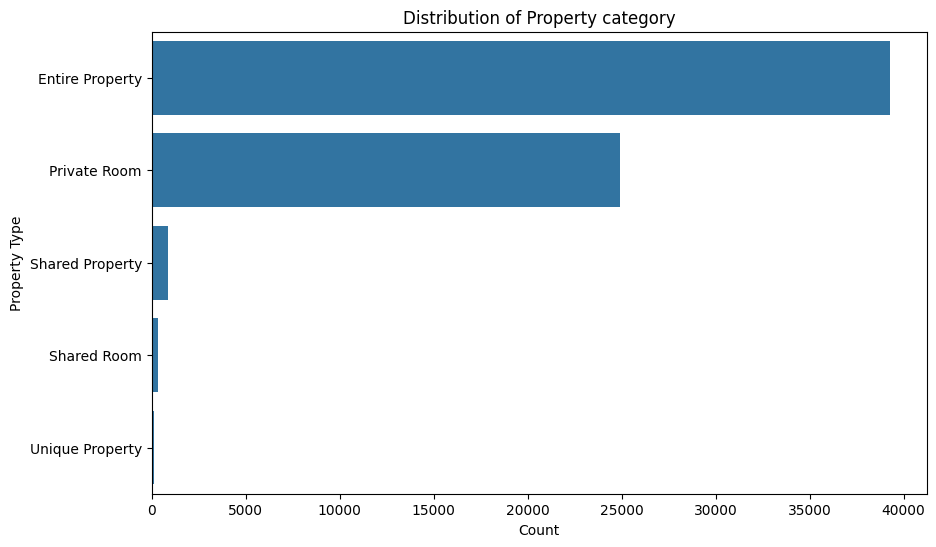

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(y='property_category', data=df_merge, order=df_merge['property_category'].value_counts().index)
plt.title('Distribution of Property category')
plt.xlabel('Count')
plt.ylabel('Property Type')
plt.show()


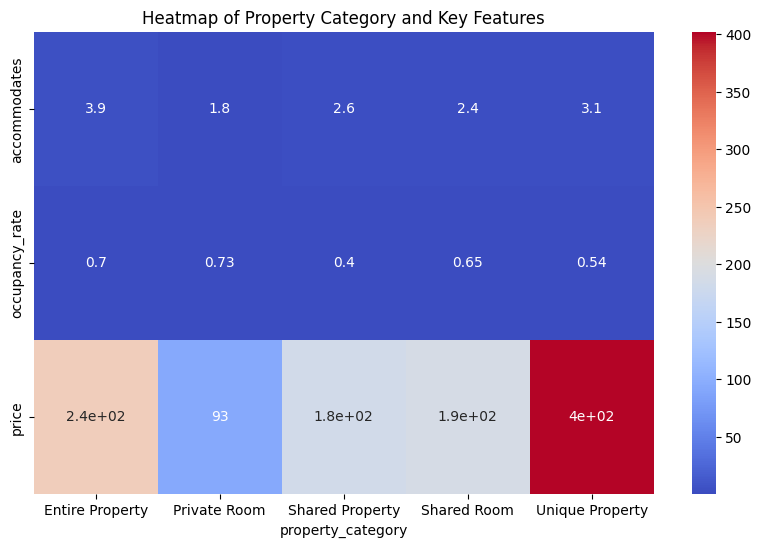

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_merge.pivot_table(index='property_category', values=['price', 'occupancy_rate', 'accommodates'], aggfunc='mean').T, annot=True, cmap='coolwarm')
plt.title('Heatmap of Property Category and Key Features')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
#linear regression for price
# Select features and target variable for pricing
X = df_merge[['property_category', 'bedrooms', 'bathrooms', 'accommodates', 'room_type']]
X = pd.get_dummies(X, drop_first=True)
y_price = df_merge['price']

# Drop rows with missing values in X or y
df_cleaned = pd.concat([X, y_price], axis=1).dropna()
X = df_cleaned.drop(columns=['price'])
y_price = df_cleaned['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
price_predictions_linear = linear_model.predict(X_test)

# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
price_predictions_rf = rf_model.predict(X_test)

# Evaluate Models
print("Linear Regression MAE:", mean_absolute_error(y_test, price_predictions_linear))
print("Linear Regression R2:", r2_score(y_test, price_predictions_linear))

print("Random Forest Regression MAE:", mean_absolute_error(y_test, price_predictions_rf))
print("Random Forest Regression R2:", r2_score(y_test, price_predictions_rf))


Linear Regression MAE: 89.07931004932912
Linear Regression R2: 0.08954765447194724
Random Forest Regression MAE: 90.33790055228468
Random Forest Regression R2: -0.09304810811113762


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Assuming df_merge is your main DataFrame and contains the necessary columns
X = df_merge[['property_category', 'bedrooms', 'bathrooms', 'accommodates', 'room_type']]
X = pd.get_dummies(X, drop_first=True)
y_occupancy = df_merge['occupancy_rate']  # Define y_occupancy here

# Combine X and y_occupancy into a single DataFrame to ensure consistency
combined_data = pd.concat([X, y_occupancy], axis=1)

# Drop any rows with missing values
combined_data = combined_data.dropna()

# Separate X and y_occupancy again after ensuring consistent lengths
X = combined_data.drop(columns=['occupancy_rate'])
y_occupancy = combined_data['occupancy_rate']

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_occupancy, test_size=0.2, random_state=42)

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
occupancy_predictions_linear = linear_model.predict(X_test)

# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
occupancy_predictions_rf = rf_model.predict(X_test)

# Evaluate Models
print("Linear Regression MAE:", mean_absolute_error(y_test, occupancy_predictions_linear))
print("Linear Regression R2:", r2_score(y_test, occupancy_predictions_linear))

print("Random Forest Regression MAE:", mean_absolute_error(y_test, occupancy_predictions_rf))
print("Random Forest Regression R2:", r2_score(y_test, occupancy_predictions_rf))


Linear Regression MAE: 0.29888020542219024
Linear Regression R2: 0.009900458377819055
Random Forest Regression MAE: 0.29578750395858866
Random Forest Regression R2: 0.012606885533927414


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Linear regression and random forest for host characteristics
# Select host characteristics and target variable for pricing
X = df_merge[['host_is_superhost', 'host_acceptance_rate', 'host_response_rate', 'host_listings_count']]
X = pd.get_dummies(X, drop_first=True)
y_price = df_merge['price']

# Drop rows with missing values in X or y
df_cleaned = pd.concat([X, y_price], axis=1).dropna()
X = df_cleaned.drop(columns=['price'])
y_price = df_cleaned['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
price_predictions_linear = linear_model.predict(X_test)

# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
price_predictions_rf = rf_model.predict(X_test)

# Evaluate Models
print("Linear Regression MAE:", mean_absolute_error(y_test, price_predictions_linear))
print("Linear Regression R2:", r2_score(y_test, price_predictions_linear))

print("Random Forest Regression MAE:", mean_absolute_error(y_test, price_predictions_rf))
print("Random Forest Regression R2:", r2_score(y_test, price_predictions_rf))


Linear Regression MAE: 130.57907963774085
Linear Regression R2: 0.007798133845208333
Random Forest Regression MAE: 118.57776028568756
Random Forest Regression R2: 0.027124008975321856


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from geopy.distance import geodesic

# Assuming you have coordinates for a major tourist attraction
tourist_attraction = (51.5074, -0.1278)  # Example: Big Ben

# Calculate distance from each listing to the tourist attraction
df_merge['distance_to_attraction'] = df_merge.apply(lambda row: geodesic((row['latitude'], row['longitude']), tourist_attraction).km, axis=1)

# Add distance to the feature set
X = df_merge[['distance_to_attraction', 'property_category', 'bedrooms', 'bathrooms', 'accommodates', 'room_type']]
X = pd.get_dummies(X, drop_first=True)
y_price = df_merge['price']
y_occupancy = df_merge['occupancy_rate']

# Ensure consistent lengths by dropping rows with missing values in X, y_price, or y_occupancy
df_combined = pd.concat([X, y_price, y_occupancy], axis=1).dropna()

# Separate back into X, y_price, and y_occupancy
X = df_combined.drop(columns=['price', 'occupancy_rate'])
y_price = df_combined['price']
y_occupancy = df_combined['occupancy_rate']

# Linear Regression Model for Price
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
price_predictions_distance = linear_model.predict(X_test)
print("Distance Impact on Price - Linear Regression R2:", r2_score(y_test, price_predictions_distance))

# Random Forest Regression Model for Price
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
price_predictions_distance_rf = rf_model.predict(X_test)
print("Distance Impact on Price - Random Forest R2:", r2_score(y_test, price_predictions_distance_rf))

# Similar steps can be taken for occupancy rates
X_train, X_test, y_train, y_test = train_test_split(X, y_occupancy, test_size=0.2, random_state=42)
linear_model.fit(X_train, y_train)
occupancy_predictions_distance = linear_model.predict(X_test)
print("Distance Impact on Occupancy - Linear Regression R2:", r2_score(y_test, occupancy_predictions_distance))

rf_model.fit(X_train, y_train)
occupancy_predictions_distance_rf = rf_model.predict(X_test)
print("Distance Impact on Occupancy - Random Forest R2:", r2_score(y_test, occupancy_predictions_distance_rf))



Distance Impact on Price - Linear Regression R2: 0.0986935069010898
Distance Impact on Price - Random Forest R2: -0.20419371357392468
Distance Impact on Occupancy - Linear Regression R2: 0.02145423390407253
Distance Impact on Occupancy - Random Forest R2: -0.15883281922700232


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from geopy.distance import geodesic

# Assuming you have coordinates for a major tourist attraction
tourist_attraction = (51.5074, -0.1278)  # Example: Big Ben

# Calculate distance from each listing to the tourist attraction
df_merge['distance_to_attraction'] = df_merge.apply(lambda row: geodesic((row['latitude'], row['longitude']), tourist_attraction).km, axis=1)

# Add distance to the feature set
X = df_merge[['distance_to_attraction', 'property_category', 'bedrooms', 'bathrooms', 'accommodates', 'room_type']]
X = pd.get_dummies(X, drop_first=True)
y_price = df_merge['price']
y_occupancy = df_merge['occupancy_rate']

# Ensure consistent lengths by dropping rows with missing values in X, y_price, or y_occupancy
df_combined = pd.concat([X, y_price, y_occupancy], axis=1).dropna()

# Separate back into X, y_price, and y_occupancy
X = df_combined.drop(columns=['price', 'occupancy_rate'])
y_price = df_combined['price']
y_occupancy = df_combined['occupancy_rate']

# Gradient Boosting Regressor for Price
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)
gbr_price = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_price.fit(X_train, y_train)
price_predictions_distance_gbr = gbr_price.predict(X_test)
print("Distance Impact on Price - Gradient Boosting R2:", r2_score(y_test, price_predictions_distance_gbr))
print("Distance Impact on Price - Gradient Boosting MAE:", mean_absolute_error(y_test, price_predictions_distance_gbr))

# Gradient Boosting Regressor for Occupancy
X_train, X_test, y_train, y_test = train_test_split(X, y_occupancy, test_size=0.2, random_state=42)
gbr_occupancy = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_occupancy.fit(X_train, y_train)
occupancy_predictions_distance_gbr = gbr_occupancy.predict(X_test)
print("Distance Impact on Occupancy - Gradient Boosting R2:", r2_score(y_test, occupancy_predictions_distance_gbr))
print("Distance Impact on Occupancy - Gradient Boosting MAE:", mean_absolute_error(y_test, occupancy_predictions_distance_gbr))



Distance Impact on Price - Gradient Boosting R2: 0.09643807176850894
Distance Impact on Price - Gradient Boosting MAE: 79.91561122092928
Distance Impact on Occupancy - Gradient Boosting R2: 0.03623796308626337
Distance Impact on Occupancy - Gradient Boosting MAE: 0.2948253502114019


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# KNN Regressor for Price
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)
knn_price = KNeighborsRegressor(n_neighbors=5)
knn_price.fit(X_train, y_train)
price_predictions_distance_knn = knn_price.predict(X_test)
print("Distance Impact on Price - KNN R2:", r2_score(y_test, price_predictions_distance_knn))
print("Distance Impact on Price - KNN MAE:", mean_absolute_error(y_test, price_predictions_distance_knn))

# KNN Regressor for Occupancy
X_train, X_test, y_train, y_test = train_test_split(X, y_occupancy, test_size=0.2, random_state=42)
knn_occupancy = KNeighborsRegressor(n_neighbors=5)
knn_occupancy.fit(X_train, y_train)
occupancy_predictions_distance_knn = knn_occupancy.predict(X_test)
print("Distance Impact on Occupancy - KNN R2:", r2_score(y_test, occupancy_predictions_distance_knn))
print("Distance Impact on Occupancy - KNN MAE:", mean_absolute_error(y_test, occupancy_predictions_distance_knn))


Distance Impact on Price - KNN R2: -0.2604415607460351
Distance Impact on Price - KNN MAE: 89.84357778719796
Distance Impact on Occupancy - KNN R2: -0.11091874447276617
Distance Impact on Occupancy - KNN MAE: 0.3006728723764616


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming df_merge is your main DataFrame and contains the necessary columns
df_merge['high_price'] = (df_merge['price'] > df_merge['price'].median()).astype(int)
df_merge['high_occupancy'] = (df_merge['occupancy_rate'] > df_merge['occupancy_rate'].median()).astype(int)

# Drop rows with missing values in X or y
df_cleaned = pd.concat([X, df_merge['high_price'], df_merge['high_occupancy']], axis=1).dropna()

# Separate back into X, y_price_class, and y_occupancy_class
X = df_cleaned.drop(columns=['high_price', 'high_occupancy'])
y_price_class = df_cleaned['high_price']
y_occupancy_class = df_cleaned['high_occupancy']

# Logistic Regression for Price
X_train, X_test, y_train, y_test = train_test_split(X, y_price_class, test_size=0.2, random_state=42)
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)
price_class_predictions = logistic_model.predict(X_test)
print("Logistic Regression Accuracy (Price):", accuracy_score(y_test, price_class_predictions))
print(classification_report(y_test, price_class_predictions))

# Logistic Regression for Occupancy
X_train, X_test, y_train, y_test = train_test_split(X, y_occupancy_class, test_size=0.2, random_state=42)
logistic_model.fit(X_train, y_train)
occupancy_class_predictions = logistic_model.predict(X_test)
print("Logistic Regression Accuracy (Occupancy):", accuracy_score(y_test, occupancy_class_predictions))
print(classification_report(y_test, occupancy_class_predictions))


Logistic Regression Accuracy (Price): 0.8386321887805568
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      3574
           1       0.81      0.88      0.84      3503

    accuracy                           0.84      7077
   macro avg       0.84      0.84      0.84      7077
weighted avg       0.84      0.84      0.84      7077

Logistic Regression Accuracy (Occupancy): 0.8838490885968631
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6255
           1       0.00      0.00      0.00       822

    accuracy                           0.88      7077
   macro avg       0.44      0.50      0.47      7077
weighted avg       0.78      0.88      0.83      7077



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Select features and target variable for pricing
X = df_merge[['property_category', 'bedrooms', 'bathrooms', 'accommodates', 'room_type']]
X = pd.get_dummies(X, drop_first=True)
y_price = df_merge['price']

# Drop rows with missing values in X or y
df_cleaned = pd.concat([X, y_price], axis=1).dropna()

# Separate back into X and y_price
X = df_cleaned.drop(columns=['price'])
y_price = df_cleaned['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)

# Gradient Boosting Regressor for Price
gbr_price = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_price.fit(X_train, y_train)
price_predictions_gbr = gbr_price.predict(X_test)

# Evaluate Model
print("Gradient Boosting Regressor MAE (Price):", mean_absolute_error(y_test, price_predictions_gbr))
print("Gradient Boosting Regressor R2 (Price):", r2_score(y_test, price_predictions_gbr))

# For Occupancy Rate
y_occupancy = df_merge['occupancy_rate']

# Drop rows with missing values in X or y
df_cleaned_occupancy = pd.concat([X, y_occupancy], axis=1).dropna()

# Separate back into X and y_occupancy
X = df_cleaned_occupancy.drop(columns=['occupancy_rate'])
y_occupancy = df_cleaned_occupancy['occupancy_rate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_occupancy, test_size=0.2, random_state=42)

# Gradient Boosting Regressor for Occupancy
gbr_occupancy = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_occupancy.fit(X_train, y_train)
occupancy_predictions_gbr = gbr_occupancy.predict(X_test)

# Evaluate Model
print("Gradient Boosting Regressor MAE (Occupancy):", mean_absolute_error(y_test, occupancy_predictions_gbr))
print("Gradient Boosting Regressor R2 (Occupancy):", r2_score(y_test, occupancy_predictions_gbr))


Gradient Boosting Regressor MAE (Price): 87.35625733494712
Gradient Boosting Regressor R2 (Price): 0.07371172774005397
Gradient Boosting Regressor MAE (Occupancy): 0.29860377549156797
Gradient Boosting Regressor R2 (Occupancy): 0.013120411910158558


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Add distance to the feature set
X = df_merge[['distance_to_attraction', 'property_category', 'bedrooms', 'bathrooms', 'accommodates', 'room_type']]
X = pd.get_dummies(X, drop_first=True)
y_price = df_merge['price']
y_occupancy = df_merge['occupancy_rate']

# Drop rows with missing values in X or y
df_cleaned = pd.concat([X, y_price, y_occupancy], axis=1).dropna()

# Separate back into X, y_price, and y_occupancy
X = df_cleaned.drop(columns=['price', 'occupancy_rate'])
y_price = df_cleaned['price']
y_occupancy = df_cleaned['occupancy_rate']

# Gradient Boosting Regressor for Price
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)
gbr_price = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_price.fit(X_train, y_train)
price_predictions_distance_gbr = gbr_price.predict(X_test)
print("Gradient Boosting Regressor R2 (Price with Distance):", r2_score(y_test, price_predictions_distance_gbr))

# Gradient Boosting Regressor for Occupancy
X_train, X_test, y_train, y_test = train_test_split(X, y_occupancy, test_size=0.2, random_state=42)
gbr_occupancy = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_occupancy.fit(X_train, y_train)
occupancy_predictions_distance_gbr = gbr_occupancy.predict(X_test)
print("Gradient Boosting Regressor R2 (Occupancy with Distance):", r2_score(y_test, occupancy_predictions_distance_gbr))



Gradient Boosting Regressor R2 (Price with Distance): 0.09643807176850894
Gradient Boosting Regressor R2 (Occupancy with Distance): 0.03623796308626337


In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Select host characteristics and target variable for pricing
X = df_merge[['host_is_superhost', 'host_acceptance_rate', 'host_response_rate', 'host_listings_count']]
X = pd.get_dummies(X, drop_first=True)
y_price = df_merge['price']

# Drop rows with missing values in X or y
df_cleaned = pd.concat([X, y_price], axis=1).dropna()

# Separate back into X and y_price
X = df_cleaned.drop(columns=['price'])
y_price = df_cleaned['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)

# Gradient Boosting Regressor for Price
gbr_price = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_price.fit(X_train, y_train)
price_predictions_gbr = gbr_price.predict(X_test)

# Evaluate Model
print("Gradient Boosting Regressor MAE (Price):", mean_absolute_error(y_test, price_predictions_gbr))
print("Gradient Boosting Regressor R2 (Price):", r2_score(y_test, price_predictions_gbr))

# For Occupancy Rate
y_occupancy = df_merge['occupancy_rate']

# Drop rows with missing values in X or y
df_cleaned_occupancy = pd.concat([X, y_occupancy], axis=1).dropna()

# Separate back into X and y_occupancy
X = df_cleaned_occupancy.drop(columns=['occupancy_rate'])
y_occupancy = df_cleaned_occupancy['occupancy_rate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_occupancy, test_size=0.2, random_state=42)

# Gradient Boosting Regressor for Occupancy
gbr_occupancy = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_occupancy.fit(X_train, y_train)
occupancy_predictions_gbr = gbr_occupancy.predict(X_test)

# Evaluate Model
print("Gradient Boosting Regressor MAE (Occupancy):", mean_absolute_error(y_test, occupancy_predictions_gbr))
print("Gradient Boosting Regressor R2 (Occupancy):", r2_score(y_test, occupancy_predictions_gbr))


Gradient Boosting Regressor MAE (Price): 124.7429629552109
Gradient Boosting Regressor R2 (Price): 0.012173239934372027
Gradient Boosting Regressor MAE (Occupancy): 0.28194830200415194
Gradient Boosting Regressor R2 (Occupancy): 0.08721786146265387


In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Select features and target variable for pricing
X = df_merge[['property_category', 'bedrooms', 'bathrooms', 'accommodates', 'room_type']]
X = pd.get_dummies(X, drop_first=True)
y_price = df_merge['price']

# Drop rows with missing values in X or y
df_cleaned = pd.concat([X, y_price], axis=1).dropna()

# Separate back into X and y_price
X = df_cleaned.drop(columns=['price'])
y_price = df_cleaned['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)

# KNN Regressor for Price
knn_price = KNeighborsRegressor(n_neighbors=5)
knn_price.fit(X_train, y_train)
price_predictions_knn = knn_price.predict(X_test)

# Evaluate Model
print("KNN Regressor MAE (Price):", mean_absolute_error(y_test, price_predictions_knn))
print("KNN Regressor R2 (Price):", r2_score(y_test, price_predictions_knn))

# For Occupancy Rate
y_occupancy = df_merge['occupancy_rate']

# Drop rows with missing values in X or y_occupancy
df_cleaned_occupancy = pd.concat([X, y_occupancy], axis=1).dropna()

# Separate back into X and y_occupancy
X = df_cleaned_occupancy.drop(columns=['occupancy_rate'])
y_occupancy = df_cleaned_occupancy['occupancy_rate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_occupancy, test_size=0.2, random_state=42)

# KNN Regressor for Occupancy
knn_occupancy = KNeighborsRegressor(n_neighbors=5)
knn_occupancy.fit(X_train, y_train)
occupancy_predictions_knn = knn_occupancy.predict(X_test)

# Evaluate Model
print("KNN Regressor MAE (Occupancy):", mean_absolute_error(y_test, occupancy_predictions_knn))
print("KNN Regressor R2 (Occupancy):", r2_score(y_test, occupancy_predictions_knn))


KNN Regressor MAE (Price): 90.49260986293626
KNN Regressor R2 (Price): 0.039465832148558366
KNN Regressor MAE (Occupancy): 0.3207174311535923
KNN Regressor R2 (Occupancy): -0.213073024707223


In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Select features and target variable for pricing based on host characteristics
X = df_merge[['host_is_superhost', 'host_acceptance_rate', 'host_response_rate', 'host_listings_count']]
X = pd.get_dummies(X, drop_first=True)
y_price = df_merge['price']

# Drop rows with missing values in X or y
df_cleaned = pd.concat([X, y_price], axis=1).dropna()

# Separate back into X and y_price
X = df_cleaned.drop(columns=['price'])
y_price = df_cleaned['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)

import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Select features and target variable for pricing based on host characteristics
X = df_merge[['host_is_superhost', 'host_acceptance_rate', 'host_response_rate', 'host_listings_count']]
X = pd.get_dummies(X, drop_first=True)
y_price = df_merge['price']

# Drop rows with missing values in X or y
df_cleaned = pd.concat([X, y_price], axis=1).dropna()

# Separate back into X and y_price
X = df_cleaned.drop(columns=['price'])
y_price = df_cleaned['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)

# KNN Regressor for Price based on Host Characteristics
knn_price = KNeighborsRegressor(n_neighbors=5)
knn_price.fit(X_train, y_train)
price_predictions_knn = knn_price.predict(X_test)

# Evaluate Model
print("KNN Regressor MAE (Price):", mean_absolute_error(y_test, price_predictions_knn))
print("KNN Regressor R2 (Price):", r2_score(y_test, price_predictions_knn))

# For Occupancy Rate based on Host Characteristics
y_occupancy = df_merge['occupancy_rate']

# Drop rows with missing values in X or y_occupancy
df_cleaned_occupancy = pd.concat([X, y_occupancy], axis=1).dropna()

# Separate back into X and y_occupancy
X = df_cleaned_occupancy.drop(columns=['occupancy_rate'])
y_occupancy = df_cleaned_occupancy['occupancy_rate']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_occupancy, test_size=0.2, random_state=42)

# KNN Regressor for Occupancy based on Host Characteristics
knn_occupancy = KNeighborsRegressor(n_neighbors=5)
knn_occupancy.fit(X_train, y_train)
occupancy_predictions_knn = knn_occupancy.predict(X_test)

# Evaluate Model
print("KNN Regressor MAE (Occupancy):", mean_absolute_error(y_test, occupancy_predictions_knn))
print("KNN Regressor R2 (Occupancy):", r2_score(y_test, occupancy_predictions_knn))


KNN Regressor MAE (Price): 130.9732599181138
KNN Regressor R2 (Price): 0.023638079363165865
KNN Regressor MAE (Occupancy): 0.27649517753293146
KNN Regressor R2 (Occupancy): -0.01973431316543195


In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Select features and target variable for pricing
X = df_merge[['distance_to_attraction', 'property_category', 'bedrooms', 'bathrooms', 'accommodates', 'room_type']]
X = pd.get_dummies(X, drop_first=True)
y_price = df_merge['price']
y_occupancy = df_merge['occupancy_rate']

# Drop rows with missing values in X or y
df_cleaned = pd.concat([X, y_price, y_occupancy], axis=1).dropna()

# Separate back into X, y_price, and y_occupancy
X = df_cleaned.drop(columns=['price', 'occupancy_rate'])
y_price = df_cleaned['price']
y_occupancy = df_cleaned['occupancy_rate']

# KNN Regressor for Price
X_train, X_test, y_train, y_test = train_test_split(X, y_price, test_size=0.2, random_state=42)
knn_price = KNeighborsRegressor(n_neighbors=5)
knn_price.fit(X_train, y_train)
price_predictions_distance_knn = knn_price.predict(X_test)
print("KNN Regressor R2 (Price with Distance):", r2_score(y_test, price_predictions_distance_knn))

# KNN Regressor for Occupancy
X_train, X_test, y_train, y_test = train_test_split(X, y_occupancy, test_size=0.2, random_state=42)
knn_occupancy.fit(X_train, y_train)
occupancy_predictions_distance_knn = knn_occupancy.predict(X_test)
print("KNN Regressor R2 (Occupancy with Distance):", r2_score(y_test, occupancy_predictions_distance_knn))


KNN Regressor R2 (Price with Distance): -0.2604415607460351
KNN Regressor R2 (Occupancy with Distance): -0.11091874447276617


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Initialize a DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Type', 'MAE', 'RMSE', 'R²'])

# Helper function to calculate regression metrics
def evaluate_regression_model(model, X_train, X_test, y_train, y_test, model_name, model_type):
    # Fit the model
    model.fit(X_train, y_train)
    # Predict on the test set
    predictions = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    # Store the results
    results.loc[len(results)] = [model_name, model_type, mae, rmse, r2]

# Assuming X and y_price, y_occupancy have been defined

# Split the data for price prediction
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X, y_price, test_size=0.2, random_state=42)

# Evaluate Regression Models for Price Prediction
evaluate_regression_model(LinearRegression(), X_train_price, X_test_price, y_train_price, y_test_price, 'Linear Regression', 'Price')
evaluate_regression_model(RandomForestRegressor(n_estimators=100, random_state=42), X_train_price, X_test_price, y_train_price, y_test_price, 'Random Forest', 'Price')
evaluate_regression_model(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42), X_train_price, X_test_price, y_train_price, y_test_price, 'Gradient Boosting', 'Price')
evaluate_regression_model(KNeighborsRegressor(n_neighbors=5), X_train_price, X_test_price, y_train_price, y_test_price, 'K-Nearest Neighbors', 'Price')

# Split the data for occupancy prediction
X_train_occupancy, X_test_occupancy, y_train_occupancy, y_test_occupancy = train_test_split(X, y_occupancy, test_size=0.2, random_state=42)

# Evaluate Regression Models for Occupancy Rate Prediction
evaluate_regression_model(LinearRegression(), X_train_occupancy, X_test_occupancy, y_train_occupancy, y_test_occupancy, 'Linear Regression', 'Occupancy')
evaluate_regression_model(RandomForestRegressor(n_estimators=100, random_state=42), X_train_occupancy, X_test_occupancy, y_train_occupancy, y_test_occupancy, 'Random Forest', 'Occupancy')
evaluate_regression_model(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42), X_train_occupancy, X_test_occupancy, y_train_occupancy, y_test_occupancy, 'Gradient Boosting', 'Occupancy')
evaluate_regression_model(KNeighborsRegressor(n_neighbors=5), X_train_occupancy, X_test_occupancy, y_train_occupancy, y_test_occupancy, 'K-Nearest Neighbors', 'Occupancy')

# Display the results
print(results)




                 Model       Type        MAE        RMSE        R²
0    Linear Regression      Price  89.407840  371.571769  0.098694
1        Random Forest      Price  91.159244  429.491564 -0.204194
2    Gradient Boosting      Price  79.915611  372.036390  0.096438
3  K-Nearest Neighbors      Price  89.843578  439.407856 -0.260442
4    Linear Regression  Occupancy   0.297618    0.333901  0.021454
5        Random Forest  Occupancy   0.302774    0.363360 -0.158833
6    Gradient Boosting  Occupancy   0.294825    0.331369  0.036238
7  K-Nearest Neighbors  Occupancy   0.300673    0.355769 -0.110919


In [ ]:
# For regression models: Sort by R²
best_regression_models = results[results['Type'].isin(['Price', 'Occupancy'])].sort_values(by='R²', ascending=False)
print("Best Regression Models Based on R²:")
print(best_regression_models)



Best Regression Models Based on R²:
                 Model       Type        MAE        RMSE        R²
0    Linear Regression      Price  89.407840  371.571769  0.098694
2    Gradient Boosting      Price  79.915611  372.036390  0.096438
6    Gradient Boosting  Occupancy   0.294825    0.331369  0.036238
4    Linear Regression  Occupancy   0.297618    0.333901  0.021454
7  K-Nearest Neighbors  Occupancy   0.300673    0.355769 -0.110919
5        Random Forest  Occupancy   0.302774    0.363360 -0.158833
1        Random Forest      Price  91.159244  429.491564 -0.204194
3  K-Nearest Neighbors      Price  89.843578  439.407856 -0.260442


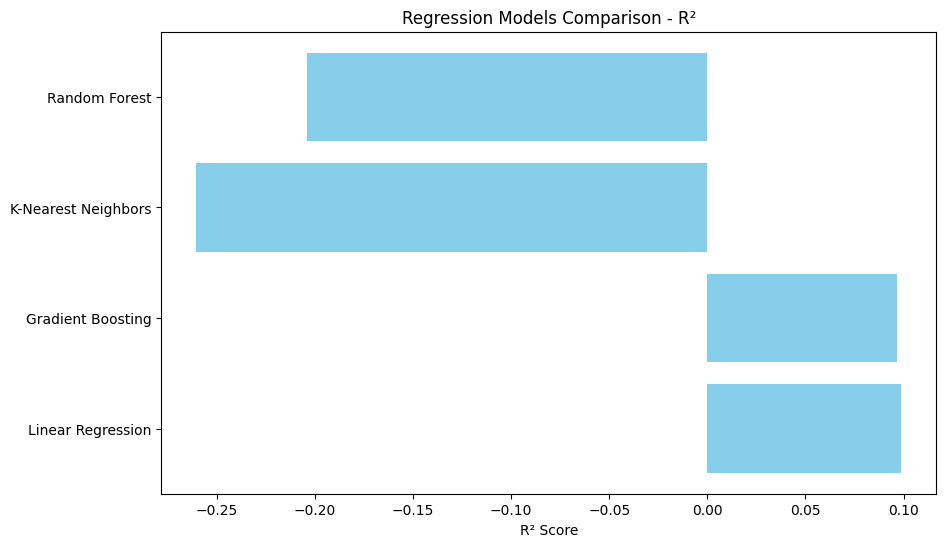

In [ ]:
import matplotlib.pyplot as plt

# Plotting the R² for Regression Models
plt.figure(figsize=(10, 6))
plt.barh(best_regression_models['Model'], best_regression_models['R²'], color='skyblue')
plt.title('Regression Models Comparison - R²')
plt.xlabel('R² Score')
plt.show()




In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error

# Combine property attributes, location factors, and host characteristics into X
X = df_merge[['distance_to_attraction', 'property_category', 'bedrooms', 'bathrooms', 'accommodates',
              'room_type', 'host_is_superhost', 'host_acceptance_rate', 'host_response_rate',
              'host_listings_count']]

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Define target variables
y_price = df_merge['price']
y_occupancy = df_merge['occupancy_rate']

# Drop rows with missing values in X or y
df_cleaned_price = pd.concat([X, y_price], axis=1).dropna()
df_cleaned_occupancy = pd.concat([X, y_occupancy], axis=1).dropna()

# Separate back into X, y_price, and y_occupancy
X_price = df_cleaned_price.drop(columns=['price'])
y_price = df_cleaned_price['price']
X_occupancy = df_cleaned_occupancy.drop(columns=['occupancy_rate'])
y_occupancy = df_cleaned_occupancy['occupancy_rate']

# Define cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List of models to validate
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(n_neighbors=5),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Validate models for Price Prediction
print("Model Validation for Price Prediction:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_price, y_price, cv=kf, scoring=make_scorer(r2_score))
    print(f"{name} - R² Scores: {cv_scores}")
    print(f"{name} - Average R² Score: {np.mean(cv_scores)}")
    print(f"{name} - MAE: {-np.mean(cross_val_score(model, X_price, y_price, cv=kf, scoring=make_scorer(mean_absolute_error)))}\n")

# Validate models for Occupancy Rate Prediction
print("Model Validation for Occupancy Rate Prediction:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_occupancy, y_occupancy, cv=kf, scoring=make_scorer(r2_score))
    print(f"{name} - R² Scores: {cv_scores}")
    print(f"{name} - Average R² Score: {np.mean(cv_scores)}")
    print(f"{name} - MAE: {-np.mean(cross_val_score(model, X_occupancy, y_occupancy, cv=kf, scoring=make_scorer(mean_absolute_error)))}\n")


Model Validation for Price Prediction:
Linear Regression - R² Scores: [0.10656486 0.2326442  0.20227367 0.03479041 0.03694006]
Linear Regression - Average R² Score: 0.12264264220719967
Linear Regression - MAE: -96.48880365007389

Random Forest Regressor - R² Scores: [ 0.03316387 -1.45337178 -0.95658517  0.00410443  0.02660561]
Random Forest Regressor - Average R² Score: -0.46921660657192776
Random Forest Regressor - MAE: -81.09985502212501

K-Nearest Neighbors Regressor - R² Scores: [-0.73974169 -0.47713893 -0.92589847 -0.05548359 -0.01237287]
K-Nearest Neighbors Regressor - Average R² Score: -0.442127110826935
K-Nearest Neighbors Regressor - MAE: -89.53771065641267

Gradient Boosting Regressor - R² Scores: [ 0.14463539  0.33379737 -0.38060388  0.04257902  0.02900287]
Gradient Boosting Regressor - Average R² Score: 0.03388215515037283
Gradient Boosting Regressor - MAE: -80.69898438201336

Model Validation for Occupancy Rate Prediction:
Linear Regression - R² Scores: [-9.23303150e+12  6

In [ ]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer

# Combine property attributes, location factors, and host characteristics into X
X = df_merge[['distance_to_attraction', 'property_category', 'bedrooms', 'bathrooms', 'accommodates',
              'room_type', 'host_is_superhost', 'host_acceptance_rate', 'host_response_rate',
              'host_listings_count']]

# Convert categorical variables to dummy/indicator variables
X = pd.get_dummies(X, drop_first=True)

# Define target variable
y_price = df_merge['price']

# Drop rows with missing values in X or y
df_cleaned_price = pd.concat([X, y_price], axis=1).dropna()

# Separate back into X and y_price
X_price = df_cleaned_price.drop(columns=['price'])
y_price = df_cleaned_price['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Define the scoring function (R²)
scoring = make_scorer(r2_score)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=scoring, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best R² Score: {grid_search.best_score_}")

# Predict on test set with the best estimator
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate the model
print("Test Set R²:", r2_score(y_test, y_pred))
print("Test Set MAE:", mean_absolute_error(y_test, y_pred))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
from graphviz import Digraph

# Initialize a Digraph
dot = Digraph(comment='Overview of Code Structure and Dependencies')

# Define the nodes
dot.node('A', 'Data Ingestion')
dot.node('B', 'Pre-processing')
dot.node('C', 'Feature Engineering')
dot.node('D', 'Modeling')
dot.node('E', 'Model Validation')
dot.node('F', 'Result Generation')

# Define the edges between nodes to show dependencies
dot.edge('A', 'B', label='Raw Data')
dot.edge('B', 'C', label='Cleaned Data')
dot.edge('C', 'D', label='Engineered Features')
dot.edge('D', 'E', label='Trained Model')
dot.edge('E', 'F', label='Validated Model')
dot.edge('B', 'D', label='Features Ready for Modeling')

# Render the diagram to a file and display it
dot.render('code_structure_overview.gv', view=True)
